# Word Embeddings

## Part I: Word2vec - the Skip-Gram model

In this notebook we will implement the Skip-Gram model using pytorch and then we will explore this powerful word representation.

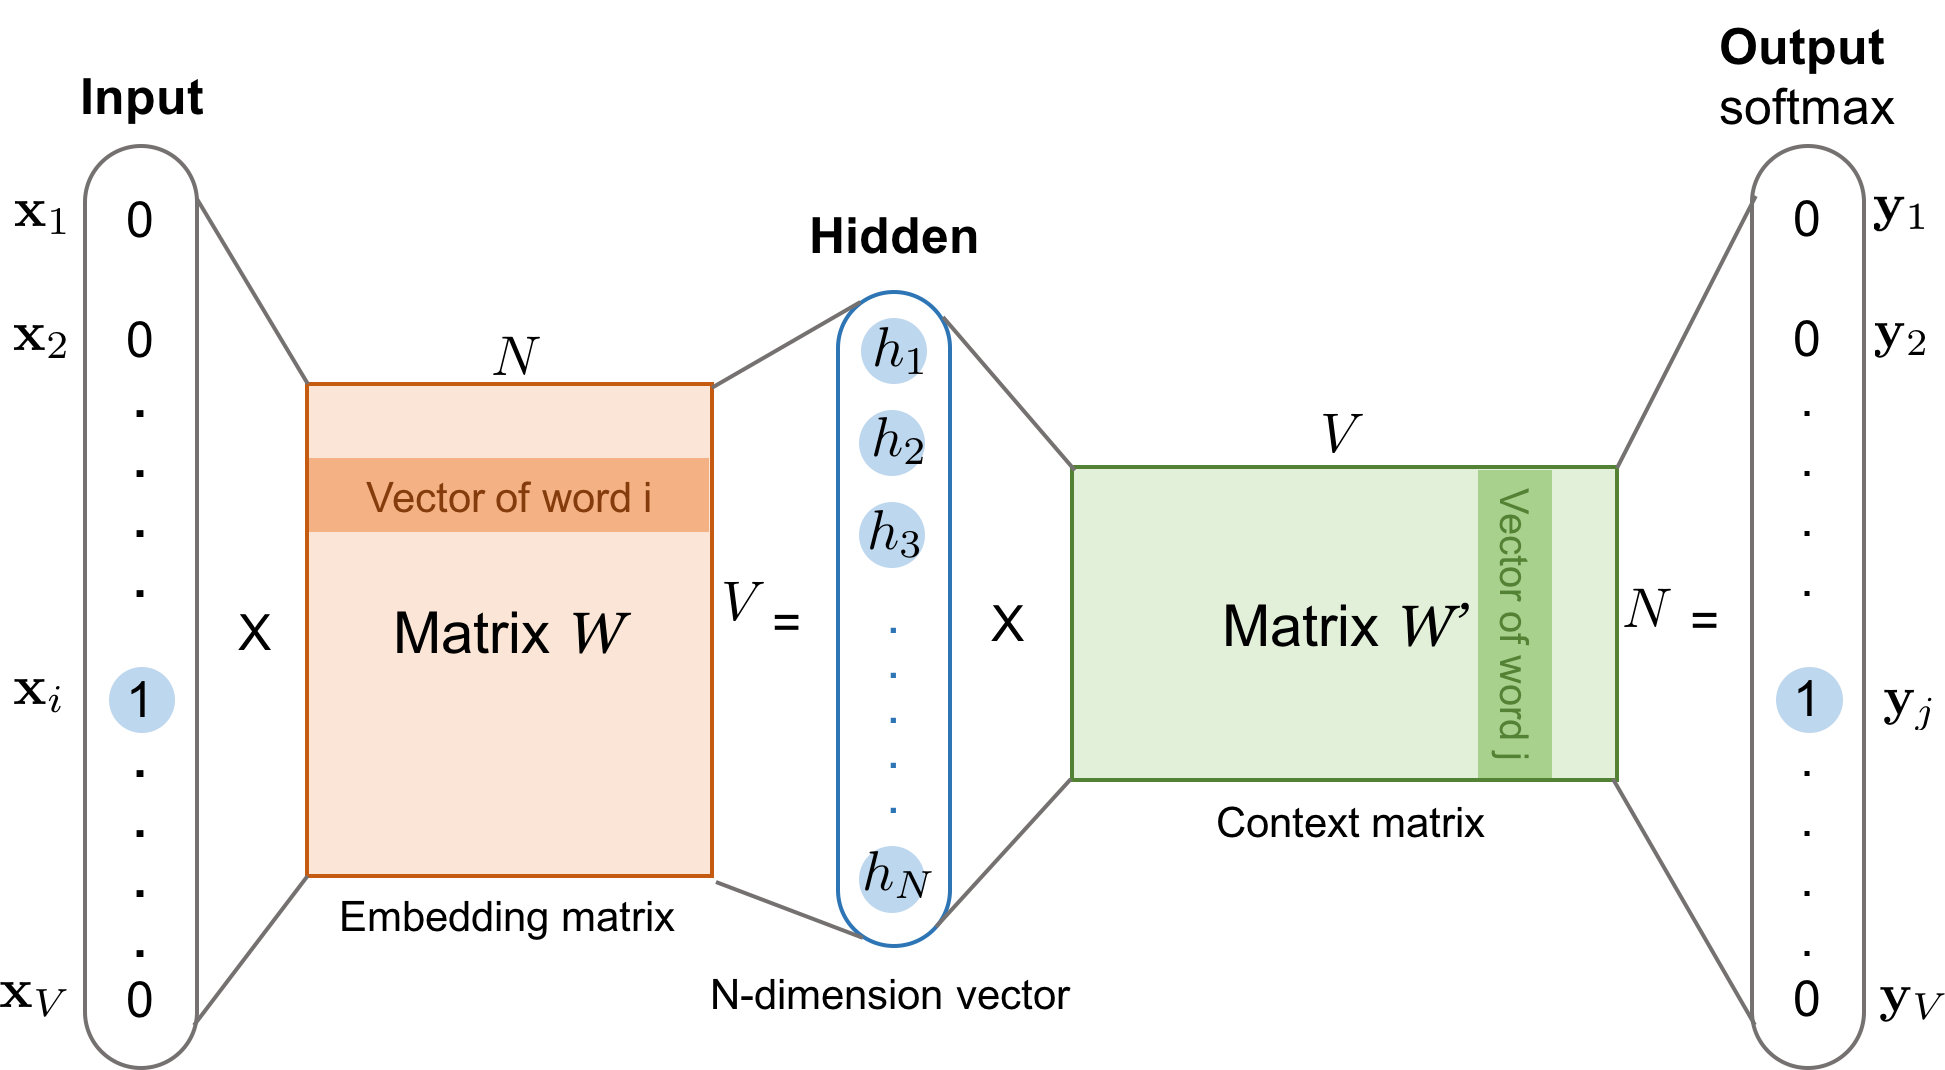

**NOTE:** this notebook requires you to install pytorch. https://anaconda.org/pytorch/pytorch

In [1]:
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

Lets start with a simple corpus:

In [10]:
corpus = [
    'he is a king',
    'she is a queen',
    'she is mad',
    'she is in love',
    'a mountain falls',
    'paris is france capital',   
]

In [11]:
def tokenize_corpus(corpus):
    tokens = [x.split() for x in corpus]
    return tokens

In [12]:
tokenized_corpus = tokenize_corpus(corpus)

In [13]:
tokenized_corpus

[['he', 'is', 'a', 'king'],
 ['she', 'is', 'a', 'queen'],
 ['she', 'is', 'mad'],
 ['she', 'is', 'in', 'love'],
 ['a', 'mountain', 'falls'],
 ['paris', 'is', 'france', 'capital']]

In [14]:
vocabulary = {word for doc in tokenized_corpus for word in doc}

In [15]:
vocabulary

{'a',
 'capital',
 'falls',
 'france',
 'he',
 'in',
 'is',
 'king',
 'love',
 'mad',
 'mountain',
 'paris',
 'queen',
 'she'}

In [16]:
word2idx = {w:idx for (idx, w) in enumerate(vocabulary)}

In [17]:
word2idx

{'is': 0,
 'she': 1,
 'mad': 2,
 'falls': 3,
 'a': 4,
 'mountain': 5,
 'he': 6,
 'queen': 7,
 'france': 8,
 'paris': 9,
 'capital': 10,
 'love': 11,
 'king': 12,
 'in': 13}

As you have seen in the theoretical lesson, we want to build pairs of words that appear within the same context.

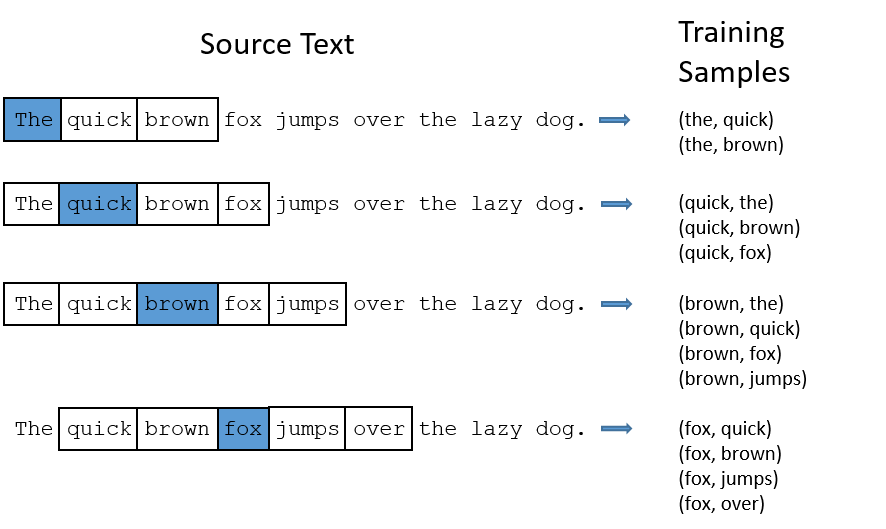

In [18]:
def build_training(tokenized_corpus, word2idx, window_size=2):
    idx_pairs = []
    
    # for each sentence
    for sentence in tokenized_corpus:
        indices = [word2idx[word] for word in sentence]
        # for each word, threated as center word
        for center_word_pos in range(len(indices)):
            # for each window position
            for w in range(-window_size, window_size + 1):
                context_word_pos = center_word_pos + w
                # make sure not jump out sentence
                if  context_word_pos < 0 or \
                    context_word_pos >= len(indices) or \
                    center_word_pos == context_word_pos:
                    continue  
                context_word_idx = indices[context_word_pos]
                idx_pairs.append((indices[center_word_pos], context_word_idx))
    return np.array(idx_pairs)

In [19]:
training_pairs = build_training(tokenized_corpus, word2idx)

In [20]:
training_pairs

array([[ 6,  0],
       [ 6,  4],
       [ 0,  6],
       [ 0,  4],
       [ 0, 12],
       [ 4,  6],
       [ 4,  0],
       [ 4, 12],
       [12,  0],
       [12,  4],
       [ 1,  0],
       [ 1,  4],
       [ 0,  1],
       [ 0,  4],
       [ 0,  7],
       [ 4,  1],
       [ 4,  0],
       [ 4,  7],
       [ 7,  0],
       [ 7,  4],
       [ 1,  0],
       [ 1,  2],
       [ 0,  1],
       [ 0,  2],
       [ 2,  1],
       [ 2,  0],
       [ 1,  0],
       [ 1, 13],
       [ 0,  1],
       [ 0, 13],
       [ 0, 11],
       [13,  1],
       [13,  0],
       [13, 11],
       [11,  0],
       [11, 13],
       [ 4,  5],
       [ 4,  3],
       [ 5,  4],
       [ 5,  3],
       [ 3,  4],
       [ 3,  5],
       [ 9,  0],
       [ 9,  8],
       [ 0,  9],
       [ 0,  8],
       [ 0, 10],
       [ 8,  9],
       [ 8,  0],
       [ 8, 10],
       [10,  0],
       [10,  8]])

In [21]:
def get_onehot_vector(word_idx, vocabulary):
    x = torch.zeros(len(vocabulary)).float()
    x[word_idx] = 1.0
    return x

def Skip_Gram(training_pairs, vocabulary, embedding_dims=5, learning_rate=0.001, epochs=10):
    
    torch.manual_seed(3)
    
    W1 = torch.randn(embedding_dims, len(vocabulary), requires_grad=True).float()
    W2 = torch.randn(len(vocabulary), embedding_dims, requires_grad=True).float()
    
    losses = []
    
    for epo in tqdm(range(epochs)):
        loss_val = 0
        
        for input_word, target in training_pairs:
            x = get_onehot_vector(input_word, vocabulary).float()
            y_true = torch.from_numpy(np.array([target])).long()

            # Matrix multiplication to obtain the input word embedding
            z1 = torch.matmul(W1, x)
    
            # Matrix multiplication to obtain the z score for each word
            z2 = torch.matmul(W2, z1)
    
            # Apply Log and softmax functions
            log_softmax = F.log_softmax(z2, dim=0) # Applies a softmax followed by a logarithm.
            
            # Compute the negative-log-likelihood loss
            loss = F.nll_loss(log_softmax.view(1,-1), y_true) # .view -> Returns a tensor with the same data but with a different shape.
            loss_val += loss.item() # -item -> Returns the value of this tensor as a standard Python number.
            
            # Compute the gradient in function of the error
            loss.backward() 
            
            # Update your embeddings
            W1.data -= learning_rate * W1.grad.data
            W2.data -= learning_rate * W2.grad.data

            W1.grad.data.zero_() 
            W2.grad.data.zero_()
            
            # .grad -> This attribute is None by default and becomes a Tensor the first time a call to backward()
            #computes gradients. The attribute will then contain the gradients computed and future 
            #calls to backward() will accumulate (add) gradients into it.
        
        losses.append(loss_val/len(training_pairs))
    
    return W1, W2, losses

In [22]:
W1, W2, losses = Skip_Gram(training_pairs, word2idx, epochs=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [23]:
def plot_loss(loss):
    x_axis = [epoch+1 for epoch in range(len(loss))]
    plt.plot(x_axis, loss, '-g', linewidth=1, label='Train')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

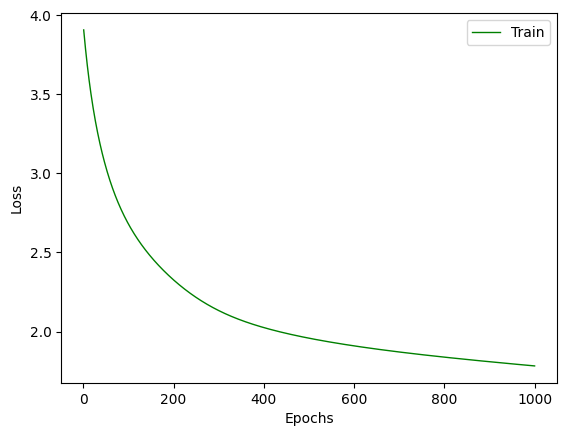

In [24]:
plot_loss(losses)

### Final Embedding Matrix

The Skip-Gram model can be implemented in 2 different ways:

- With shared parameters, meaning that, $W_1$ and $W_2$ are the same matrix.
- Without shared paramenters across layers, meaning that, in the end, we have two different matrixes with weights. The final matrix $W$ is the average of both matrixes.

In [25]:
W = W1 + torch.t(W2)
W = (torch.t(W)/2).clone().detach()

In [26]:
W[word2idx["she"]], W[word2idx["mad"]]

(tensor([ 0.4046,  0.0637,  0.5388, -0.2995,  0.8249]),
 tensor([ 0.0673,  0.0292,  1.4983, -0.1255,  0.7085]))

In [28]:
from sklearn.metrics.pairwise import euclidean_distances

euclidean_distances([W[word2idx["she"]].numpy()], [W[word2idx["falls"]].numpy()])

array([[2.7502258]], dtype=float32)

In [29]:
euclidean_distances([W[word2idx["she"]].numpy()], [W[word2idx["mad"]].numpy()])

array([[1.0389657]], dtype=float32)

As you can see from the previous example the vector representing "she" and the vector representing "mad" are closer then the vector representing "she" and "falls". This happens because "she" and "falls" never appear together inside the same context window.

Now, we will change the Skip-Gram function in order to have only 1 matrix of weights instead of 2, and run the training again.

In [30]:
def Skip_Gram(training_pairs, vocabulary, embedding_dims=5, learning_rate=0.001, epochs=10):
    
    torch.manual_seed(3)
    
    W1 = torch.randn(embedding_dims, len(vocabulary), requires_grad=True).float()
    
    losses = []
    
    for epo in tqdm(range(epochs)):
        loss_val = 0
        
        for input_word, target in training_pairs:
            x = get_onehot_vector(input_word, vocabulary).float()
            y_true = torch.from_numpy(np.array([target])).long()

            # Matrix multiplication to obtain the input word embedding
            z1 = torch.matmul(W1, x)
    
            # Matrix multiplication to obtain the z score for each word
            z2 = torch.matmul(z1, W1)
    
            # Apply Log and softmax functions
            log_softmax = F.log_softmax(z2, dim=0)
            
            # Compute the negative-log-likelihood loss
            loss = F.nll_loss(log_softmax.view(1,-1), y_true)
            loss_val += loss.item()
            
            # Compute the gradient in function of the error
            loss.backward() 
            
            # Update your embeddings
            W1.data -= learning_rate * W1.grad.data
            
            W1.grad.data.zero_()
        
        losses.append(loss_val/len(training_pairs))
    
    return W1, losses

In [31]:
W1, losses = Skip_Gram(training_pairs, word2idx, epochs=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

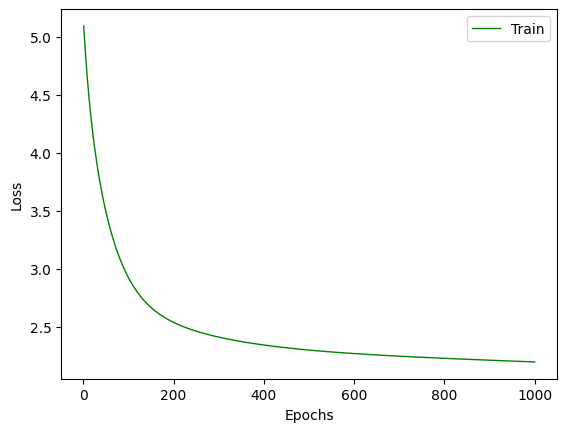

In [32]:
plot_loss(losses)

In [33]:
W = torch.t(W1).clone().detach()

In [34]:
W[word2idx["she"]], W[word2idx["mad"]]

(tensor([0.5533, 0.8081, 0.7570, 0.6252, 1.0316]),
 tensor([0.2417, 0.2890, 1.1372, 0.2896, 0.7255]))

In [35]:
from sklearn.metrics.pairwise import euclidean_distances

euclidean_distances([W[word2idx["she"]].numpy()], [W[word2idx["falls"]].numpy()])

array([[2.4801273]], dtype=float32)

In [36]:
euclidean_distances([W[word2idx["she"]].numpy()], [W[word2idx["mad"]].numpy()])

array([[0.84699345]], dtype=float32)

### Word Embeddings Visualization

Go to https://projector.tensorflow.org/ and visualize Word2Vec embeddings. 

Original Word2Vec repository: https://code.google.com/archive/p/word2vec/

## Part II: Exploring Word Vectors with GloVe

As we have seen, the Word2vec algorithms (such as Skip-Gram) predicts words in a context (e.g. what is the most likely word to appear in "the cat ? the mouse"). GloVe vectors are based on global counts across the corpus.  

The advantage of GloVe is that, unlike Word2vec, GloVe does not rely just on local statistics (local context information of words), but incorporates global statistics (word co-occurrence) to obtain word vectors — see [How is GloVe different from word2vec?](https://www.quora.com/How-is-GloVe-different-from-word2vec) and [Intuitive Guide to Understanding GloVe Embeddings](https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010)  for some better explanations.

Multiple sets of pre-trained GloVe vectors are easily available for [download](https://nlp.stanford.edu/projects/glove/), so that's what we'll use here.

Part II of this notebook is taken from [practical-pytorch tutorials](https://github.com/spro/practical-pytorch/blob/master/glove-word-vectors/glove-word-vectors.ipynb)

### Loading word vectors

Torchtext includes functions to download GloVe (and other) embeddings

In [ ]:
#!pip install torchtext

In [38]:
import torch
import torchtext.vocab as vocab

In [39]:
glove = vocab.GloVe(name='6B', dim=50)
print('Loaded {} words'.format(len(glove.itos)))

.vector_cache/glove.6B.zip: 862MB [11:51, 1.21MB/s]                             
100%|███████████████████████████████▉| 399999/400000 [00:04<00:00, 87902.98it/s]


Loaded 400000 words


Loaded 400000 words.

The returned GloVe object includes attributes:

- `stoi` - string-to-index - returns a dictionary of words to indexes.
- `itos` - index-to-string - returns an array of words by index.
- `vectors`- returns the actual vectors. 

To get a word vector get the index to get the vector:

In [31]:
def get_word(word):
    return glove.vectors[glove.stoi[word]]

### Finding the closest vectors

Going from word → vector is easy enough, but to go from vector → word takes more work. Here we're (naively) calculating the distance for each word in the vocabulary, and sorting based on that distance:

In [32]:
def closest(vec, n=10):
    """
    Find the closest words for a given vector
    """
    all_dists = [(w, torch.dist(vec, get_word(w))) for w in tqdm(glove.itos)]
    return sorted(all_dists, key=lambda t: t[1])[:n]

In [33]:
closest(get_word('google'))

  0%|          | 0/400000 [00:00<?, ?it/s]

[('google', tensor(0.)),
 ('yahoo', tensor(2.3412)),
 ('aol', tensor(2.8021)),
 ('microsoft', tensor(3.1196)),
 ('facebook', tensor(3.1771)),
 ('web', tensor(3.2440)),
 ('ebay', tensor(3.2447)),
 ('netscape', tensor(3.3700)),
 ('internet', tensor(3.4071)),
 ('msn', tensor(3.4756))]

This will return a list of (word, distance) tuple pairs. Here's a helper function to print that list:

In [34]:
def print_tuples(tuples):
    for tuple in tuples:
        print('(%.4f) %s' % (tuple[1], tuple[0]))

Now using a known word vector we can see which other vectors are closest:

In [35]:
print_tuples(closest(get_word('google')))

  0%|          | 0/400000 [00:00<?, ?it/s]

(0.0000) google
(2.3412) yahoo
(2.8021) aol
(3.1196) microsoft
(3.1771) facebook
(3.2440) web
(3.2447) ebay
(3.3700) netscape
(3.4071) internet
(3.4756) msn


### Word analogies with vector arithmetic
The most interesting feature of a well-trained word vector space is that certain semantic relationships (beyond just close-ness of words) can be captured with regular vector arithmetic.

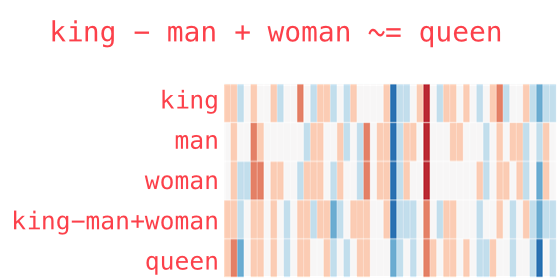


(image borrowed from https://jalammar.github.io/illustrated-word2vec/)

Read [The Illustrated Word2vec](https://jalammar.github.io/illustrated-word2vec/) for more information.

In [36]:
# In the form w1 : w2 :: w3 : ?
def analogy(w1, w2, w3, n=5, filter_given=True):
    # w2 - w1 + w3 = w4
    closest_words = closest(get_word(w2) - get_word(w1) + get_word(w3))
    print('\n[%s - %s + %s = ?]' % (w1, w2, w3))
    # Optionally filter out given words
    if filter_given:
        closest_words = [t for t in closest_words if t[0] not in [w1, w2, w3]]
        
    print_tuples(closest_words[:n])

In [37]:
analogy('king', 'man', 'queen')

  0%|          | 0/400000 [00:00<?, ?it/s]


[king - man + queen = ?]
(2.8391) woman
(3.3545) girl
(3.9518) boy
(4.0233) her
(4.0554) herself


Now let's explore the word space and see what stereotypes we can uncover:

In [ ]:
analogy('man', 'actor', 'woman')
#analogy('cat', 'kitten', 'dog')
#analogy('dog', 'puppy', 'cat')
#analogy('russia', 'moscow', 'france')
#analogy('obama', 'president', 'trump')
#analogy('rich', 'mansion', 'poor')
#analogy('elvis', 'rock', 'eminem')
#analogy('paper', 'newspaper', 'screen')
#analogy('monet', 'paint', 'michelangelo')
#analogy('beer', 'barley', 'wine')
#analogy('earth', 'moon', 'sun')
#analogy('house', 'roof', 'castle')
#analogy('building', 'architect', 'software')
#analogy('boston', 'bruins', 'phoenix')
#analogy('good', 'heaven', 'bad')
#analogy('jordan', 'basketball', 'woods')

  0%|          | 0/400000 [00:00<?, ?it/s]


[man - actor + woman = ?]
(2.0527) actress
(3.6065) starred
(3.8781) comedian
(3.9407) starring
(3.9920) entertainer


  0%|          | 0/400000 [00:00<?, ?it/s]

# Term-Document Matrix

In [ ]:
df = pd.read_csv("Corona_NLP.csv", encoding='latin-1')
pd.options.display.max_colwidth = 500
df.head(10)

In [ ]:
df  = df[['OriginalTweet', 'Sentiment']].head(10000)

In [ ]:
set(df['Sentiment'].values)

In [ ]:
df['LabelSentiment'] = df['Sentiment'].apply(lambda x: 1 if x in ['Extremely Positive', 'Positive', 'Neutral'] else 0)

In [ ]:
df.head()

## Train - Test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['OriginalTweet'], df['LabelSentiment'], test_size=0.20, random_state=4)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

## Clean Text

In [ ]:
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()

In [ ]:
def clean(text_list):
    
    updates = []
    
    for j in tqdm(text_list):
        
        text = j
        
        #LOWERCASE TEXT
        text = text.lower()
        
        #REMOVE NUMERICAL DATA and PUNCTUATION
        text = re.sub("[^a-zA-Z]"," ", text )
        
        #REMOVE STOPWORDS
        text = " ".join([word for word in text.split() if word not in stop])
        
        #Lemmatize
        text = " ".join(lemma.lemmatize(word) for word in text.split())
            
        updates.append(text)
        
    return updates

In [ ]:
X_train_clean = clean(X_train)

In [ ]:
X_test_clean = clean(X_test)

## Feature Engineering - Term-Document Matrix

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# Create a Counter of tokens
count_vectorizer = CountVectorizer()
X_train_td = count_vectorizer.fit_transform(X_train_clean)
X_test_td = count_vectorizer.transform(X_test_clean)

In [ ]:
# Extract the vocabulary as a list of (word, frequency)
vocab = list(count_vectorizer.vocabulary_.items())
print(vocab[:10])

In [ ]:
y = y_train.to_numpy()

In [ ]:
y

In [ ]:
y_test = y_test.to_numpy()

## Train and Predict

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression(random_state=0)

In [ ]:
lr.fit(X_train_td,y)

In [ ]:
lr_pred = lr.predict(X_test_td)

In [ ]:
lr_pred

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, lr_pred))

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(lr_pred, y_test)

### MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
mlp = MLPClassifier(solver='adam', hidden_layer_sizes=(2,2), activation='logistic', random_state=1)

In [ ]:
mlp.fit(X_train_td,y)

In [ ]:
mlp_pred = mlp.predict(X_test_td)

In [ ]:
print(classification_report(y_test, mlp_pred))

In [ ]:
confusion_matrix(mlp_pred, y_test)